<center>
<h1>Youtube Scam Comment Classification</h1>

By David Andrés Sanchez and Juan Becerro Campos
</center>


<h2> Index </h2>
<ul> 
    <li>Context</li>
    <li>Targets</li>
    <li>Process</li>
    <li>Metrics</li>
    <li>Conclussion</li>
</ul>



<h2> Process </h2>

<p>
First we have to import the necesary libraries to create our model, mainly we will need pandas for dataset management, numpy for mathematical operations, matplotlib to plot our data, re/nltk for text processing, sklearn for the Model creation itself.
</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

import os
import json

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

<p>
First we import our initial dataset, this dataset was created by us using the google API. We made a script 'DatasetGeneration.py' that connects to the google API, and makes a query for the comment data of certain youtube video we though could be appropiate for the task.
</p>

In [3]:
Comments = []
commentsId = []
repliesCount = []
isReplies = []
Usernames = []
UserIds = []

for i in range(0, 1000):
            
    if not os.path.exists(f'hD1YtmKXNb4/{i}.json'): 
        break

    with open(f'hD1YtmKXNb4/{i}.json', 'r') as openfile:
        # Reading from json file
        response = json.load(openfile)

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_id = item['snippet']['topLevelComment']['id']
            reply_count = item['snippet']['totalReplyCount']
            isReply = False
            authorName = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            
            if 'authorChannelId' in item['snippet']['topLevelComment']['snippet']:
                authorId =  item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            else:
                authorId = None

            #append to lists
            Comments.append(comment)
            commentsId.append(comment_id)
            repliesCount.append(reply_count)
            isReplies.append(isReply)
            Usernames.append(authorName)
            UserIds.append(authorId)

            if reply_count > 0 and 'replies' in item:
                for reply in item['replies']['comments']:
                    reply_comment = reply['snippet']['textDisplay']
                    reply_comment_id = reply['id']
                    reply_reply_count = 0
                    isReply = True
                    reply_author_name = reply['snippet']['authorDisplayName']
                    if 'authorChannelId' in reply['snippet']:
                        reply_author_id = reply['snippet']['authorChannelId']['value']
                    else:
                        reply_author_id = None

                    #append to lists
                    Comments.append(reply_comment)
                    commentsId.append(reply_comment_id)
                    repliesCount.append(reply_reply_count)
                    isReplies.append(isReply)
                    Usernames.append(reply_author_name)
                    UserIds.append(reply_author_id)

zipped = list(zip(Comments, commentsId, repliesCount, isReplies, Usernames, UserIds))

data = pd.DataFrame(zipped, columns=["Comments", "Comment ID", "Reply Count", "Is Reply", "Author", "AuthorID"])
#data = pd.read_csv('comments.csv', sep=',', header=0)
data.head()

,Comments,Comment ID,Reply Count,Is Reply,Author,AuthorID
0,I hope you guys like the new video concept :),UgzXpQ-MqCv9qFrJX-J4AaABAg,384,False,MrBeast,UCX6OQ3DkcsbYNE6H8uQQuVA
1,your mom,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_r9Qou0luY,0,True,ry kb,UCsstKyC1CPj3wreooY4hOTQ
2,Y r best,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_f1uKkX_rM,0,True,Debashis Bhattacharjee,UCf-dsJptn7VzK4C8jbMljLw
3,Last,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRcKc106,0,True,Niloy Zaman,UCtK2uwqQwCElqNN067Iod4w
4,I love you,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRQSSdEj,0,True,RedTune605,UCFlNRv9FlLyypfrvBTQkjTw


### The Dataset
<p>
The dataset is composed of six columns and 109585 rows.The first column is the comment itself without any text processing, then the Comment ID, the number of replies, the Author of the comment, and finally the user ID.

The dataset itself is not classified, so we had to manually classify the comments manually. This sounds like a very tedious task, but thanks to the nature of the problem, and the data avaliable, we can create a list of known scam comment users and automatically classify all coments this user has on the dataset; this is very effective because normaly a scam comment user will post several comments.
</p>


In [222]:
data[data['Is Reply'] == True][12000:12010]

,Comments,Comment ID,Reply Count,Is Reply,Author,AuthorID,Is Scam
25286,I've got something special for you!',UgxRlSBfCkz-wRNkzNd4AaABAg.9_uJGCy0Q8S9_uJJxHKLcW,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1
25289,I've got something special for you!',Ugwuc5MvejIfEv47tot4AaABAg.9_uJ4Wjjlr69_uJFOFOqsN,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1
25291,I've got something special for you!',Ugzk06-1pNICrnXYa8h4AaABAg.9_uJ2IdRDW89_uJGIbHG2L,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1
25293,I've got something special for you!',Ugzq_97gpad7PteOAE94AaABAg.9_uJ0fgosb-9_uJHCCwRiH,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1
25295,This is my lucky day. ! Thanks for the respons...,UgwTzf3rjDf1Q9Vz7lF4AaABAg.9_uIyjhXCI99_uLeR6B8wM,0,True,bernard bernido,UCYJnZr65zOKegM9h9nTVAFQ,0
25296,What is that.? Thank u.!,UgwTzf3rjDf1Q9Vz7lF4AaABAg.9_uIyjhXCI99_uJhTo6VFo,0,True,bernard bernido,UCYJnZr65zOKegM9h9nTVAFQ,0
25297,I've got something special for you!',UgwTzf3rjDf1Q9Vz7lF4AaABAg.9_uIyjhXCI99_uJI6xbOGD,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1
25299,I've got something special for you🎁,UgyzbKf2XFhL8IGolAJ4AaABAg.9_uIZQX3UQU9_uIaUAQd9W,0,True,telegram me @mrbeast171,UC4BTXtDeOzz85XMShFWY1VA,1
25301,I've got something special for you🎁.,UgzCaXxmDuWJS0SVp_94AaABAg.9_uIXVzn-le9_uIoALpyML,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1
25303,I've got something special for you🎁.,Ugxg_Ul_LphpZbtw7LF4AaABAg.9_uITu_jm9j9_uIpcSbN2-,0,True,Telegram me👉SteveWill55,UClmXrUcfU0A3BWSCU1XouNg,1


In [217]:
scamChannels = ['UCwgMHGG8IDcYjjSXtYbE9rQ', 'UC8Oy99fOvCjHfbvTImDXpkg',
'UCswOElw6g7pEeAA5Mu15p3Q', 'UCIknJ8HTOMLSfIAmtsm84vA', 'UCsXIMkerN0ofYQVIvNWr7Dg', 'UC5iFMKp-Tuf2RX8wTDIA00w',
'UC4BTXtDeOzz85XMShFWY1VA', 'UCIIab0_13sTLxQY66QjpM-g', 'UCZIIrgNdsq0MPdbG6utOLmw', 'UCf3mY9fz0oesuFS4fUnhjsg',
'UCii92DZYgGqYquT71D9cWSQ', 'UCSkoxrUobYERf5FI1F0KDTg', 'UCbdM2ysSVcPxHghp50tiPQw', 'UC1Wi-CaZ_u111EET3es-jzA',
'UCJB7ZvEbo-xRZum_3Zmq9sw', 'UCe5DcGeti6adyFedf49MRuA', 'UCfOYoX3Cwcn0A8t32c3cM5g', 'UCIAYvaVP15Cel4NZ1ib_ADA',
'UCgvlSYolCHq5JiiosIvM6lw', 'UCcxxhVKa9wVvHXscwMXC2gQ', 'UCs5NZ-lIbR_rvYDaKvBrVFw', 'UCMhUkjPmAi9xrbskMrdNPWA',
'UCHCtAgNRSrcBMRqU5SfHplw', 'UC07gLBHCOrcOyE0bw8Lv8Jg', 'UCnOW6JnwbE46hKOPyDYxc_w', 'UCLlW4UJkWDqW9Ht4u8LRztw',
'UCoPBjpeflrKudIDsvDEV0aw', 'UCcoKvgQgWLXosFP5giUeI4g', 'UChYGnlCGDagZT0F8GYhDY2w', 'UCapA77PmpW9dEZQxxJY7TIg',
'UCfdoVOJ9krvIZReKoLWAelA', 'UCU5WWthBfCSYPt-YRNRZYPQ', 'UCDDbjiG_3PHqn4_8BRMr9yA', 'UCVnjpK8HoaeYGQCJUjtiq6g',
'UCkJePyY8lKMvWSF9S-X_hpQ', 'UCwRfjTiJGrONLlNHFQ0mQ2A', 'UCJoDuLaZaOmmTLk9IVst6OA', 'UCk4bBXoqPm8j2FjyStas7jQ',
'UC6M_UOk3D8ZG0J2HmuK6J7g', 'UCgHM7Mjvat503rAX9jlFf3w', 'UCzywEh2M-ReJTvlPh-jA1-w', 'UClmn1s3aSJcqsGoQG7ZV5rg',
'UClmXrUcfU0A3BWSCU1XouNg', 'UCDhBrg4uKxdc0u5mv2x9GAA', 'UC4A5Ov8NNZ8K1Lq5cfcESUg', 'UC7qpkq26VEDSe6H3ZwTMWJg',
'UCk44Jx55IZkD57On49NFtiw', 'UCPDuYbsUJxNexaCBruG-jkw', 'UCOqxwnL0H8oCTHlBNO9uSGQ', 'UCblmGPQJ1_O_gBMmGRiVM9Q',
'UC4IerKEP2BDFd2VVXLaeU7w', 'UChoTld7IoAinX5E7nYTZJVg', 'UCYbUqEvxVhVh71wBbrgvyGA', 'UCEmzN-PVaElRDmdlBFbMW1A',
'UCNBOZg8v0cFe2RYvSgJ_K3A', 'UCpTKksadLBwHiFOdtxVq5Sg', 'UCkGvXvq42A152M8S5xOMbBw', 'UC4kPR2QLYHmURMMr5ERPAcA',
'UCJ4a59zmaTKVThYBU-ZZdFA', 'UCV_Qh1S9gCCXm2XBQRy0v8Q', 'UCgP6tTK8LrlhK7LMhExs6eQ', 'UCRqHZqWr81nXW0Qr2MVcD-g',
'UCfH5_gBNYMszkN-6P1SAC1Q', 'UCYGbbdOfUAtBOFoiifA4cpw', 'UCFSHMdKANs7Ee_xAfvfX7ug', 'UChYuxekYJM1HXY6ThthPR8A',
'UCXLbuE7gWN6CVyliQHKP62w', 'UCpd3kplR9EdsvjbCAtp1JPw', 'UCOLzBAcpeCiue5PnlPSvczQ', 'UC0anupzl59WSN3XiwtcskaA',
'UClLJBDGFBNEvfuqO7mnISDA', 'UCINx9NBUBTrtejzu6j_Msrw', 'UCnoWpxUsITYEz7PN5gUnjig', 'UCFRi7Mrj-Eg4QWDo4hklyNQ',
'UCjq5OmDN3GpsEJnC7IN2wrw', 'UC-qClLgMIxMzxutSFCX3Z7Q', 'UCf4yPu2n776Y4UNyOrgBGyw', 'UCKXxgBp0ayWv9ltjB7JdjSw',
'UCuftC8pB9Qkp7NgfDDTWogQ', 'UCrdtt67J70SGqUbmpzsZB7A', 'UC0ALSPkH0CWGHWQnjKqUcZA', 'UChDOklT_Llw8Fhe73S_V9uA',
'UCXKK2TaXBVTFLoVThFZ7xjw', 'UC4Az0jfOzfLEye0hFMVddpw', 'UC4paLTpfQMaGw3fGTVhhgDg', 'UCPuAuTprV61plFTD7a6Xb2w',
'UCZMhE9u0wSQhRiEfca5q8Gg', 'UCG5f10-PAcrTQzofSen_reA'
]

def isScam(id):

    if  id in scamChannels:
        return 1
    else:
        return 0


data['Is Scam'] = data['AuthorID'].apply(lambda x: isScam(x))
data.head()

,Comments,Comment ID,Reply Count,Is Reply,Author,AuthorID,Is Scam
0,I hope you guys like the new video concept :),UgzXpQ-MqCv9qFrJX-J4AaABAg,384,False,MrBeast,UCX6OQ3DkcsbYNE6H8uQQuVA,0
1,your mom,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_r9Qou0luY,0,True,ry kb,UCsstKyC1CPj3wreooY4hOTQ,0
2,Y r best,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_f1uKkX_rM,0,True,Debashis Bhattacharjee,UCf-dsJptn7VzK4C8jbMljLw,0
3,Last,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRcKc106,0,True,Niloy Zaman,UCtK2uwqQwCElqNN067Iod4w,0
4,I love you,UgzXpQ-MqCv9qFrJX-J4AaABAg.9_bg2ijaDI19_bgRQSSdEj,0,True,RedTune605,UCFlNRv9FlLyypfrvBTQkjTw,0


Now we will separate our dataset in two parts, the first one will contain the first 30000 rows, and will be our training data, and our second one, that will contain the next 5000 rows will be our test dataset.

In [218]:
train = data[0:30000].copy()[['Comments', 'Is Reply', 'Author', 'Is Scam']]
test = data[30001:35001].copy()[['Comments', 'Is Reply', 'Author', 'AuthorID']]

We can see how many scam comments we classified from our training data.

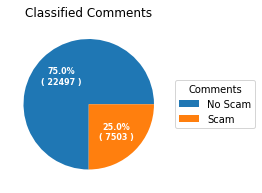

In [219]:
#plot
x = train['Is Scam'].value_counts()

def label(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n( {:d} )".format(pct, absolute)

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(x, autopct=lambda pct:label(pct, x), textprops=dict(color="w"))
ax.legend(wedges, ["No Scam", "Scam"], title="Comments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Classified Comments")
plt.setp(autotexts, size=8, weight="bold")
plt.show()

In [58]:
train['Word Count'] = train['Comments'].apply(lambda x: len(str(x).split()))
print(train[train['Is Scam']==1]['Word Count'].mean())
print(train[train['Is Scam']==0]['Word Count'].mean())

10.441671340437464
8.591131712436592


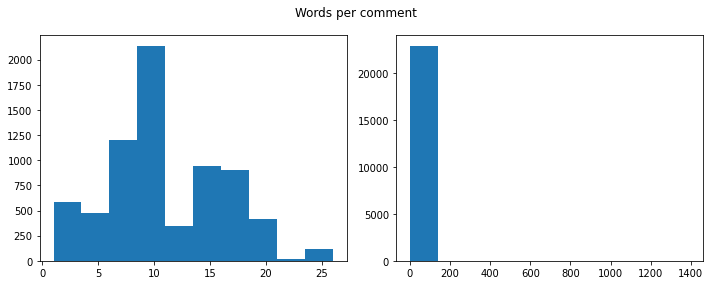

In [59]:
# PLOTTING WORD-COUNT
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(10, 4))
train_scam_words=train[train['Is Scam']==1]['Word Count']
train_noScam_words=train[train['Is Scam']==0]['Word Count']

ax1.hist(train_scam_words, bins=10, histtype='bar')
ax2.hist(train_noScam_words, bins=10, histtype='bar')


fig.suptitle('Words per comment')
fig.tight_layout()
plt.show()

<p>
Now we need to process our Comments and Usernames, to do this, we will convert to lowercase, strip and remove punctuations from each comment, and then we will use nltk to lemmatize and tokenize the text. This way, our text will be processed and ready to vectorize it so it can be used by a ML model.
</p>

In [61]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = str(text).lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))


train['Clean Comment'] = train['Comments'].apply(lambda x: finalpreprocess(x))
train['Clean Author'] = train['Author'].apply(lambda x: finalpreprocess(x))
train['Clean text tokens']=[nltk.word_tokenize(i) for i in train['Clean Comment']]
train['Clean Author tokens']=[nltk.word_tokenize(i) for i in train['Clean Author']]


In [69]:
train.head()

,Comments,Is Reply,Author,Is Scam,Word Count,Clean Comment,Clean Author,Clean text tokens,Clean Author tokens
0,I hope you guys like the new video concept :),False,MrBeast,0,10,hope guy like new video concept,mrbeast,"[hope, guy, like, new, video, concept]",[mrbeast]
1,your mom,True,ry kb,0,2,mom,ry kb,[mom],"[ry, kb]"
2,Y r best,True,Debashis Bhattacharjee,0,3,r best,debashis bhattacharjee,"[r, best]","[debashis, bhattacharjee]"
3,Last,True,Niloy Zaman,0,1,last,niloy zaman,[last],"[niloy, zaman]"
4,I love you,True,RedTune605,0,3,love,redtune,[love],[redtune]


<p>
We can see how now in the columns 'Clean text Tokens' and 'Clean Author tokens' we have lists of word tokens instead of the preprocessed text we can read in the column 'Comments' or 'Author'
</p>

<p>
Now we will sepparate our training data into four dataframes X_train, X_test, y_train, y_test. This is to train our model.
</p>

In [187]:
X_train, X_test, y_train, y_test = train_test_split(train['Clean Comment'], train['Is Scam'], test_size=0.4, shuffle=True)
X_train_author, X_test_author, y_train_author, y_test_author = train_test_split(train['Clean Author'], train['Is Scam'], test_size=0.4, shuffle=True)

<p>
Now we create a Tf-idf vectorizer with our processed text.
</p>

In [142]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=10)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer')

author_tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=5)
X_train_vectors_tfidf_author = author_tfidf_vectorizer.fit_transform(X_train_author) 
X_test_vectors_tfidf_author = author_tfidf_vectorizer.transform(X_test_author)
joblib.dump(author_tfidf_vectorizer, 'author_tfidf_vectorizer')


['author_tfidf_vectorizer']

<p>
In order to visualize the tf-idf results, here we can see how are the top 50 features for the comments are ordered by label. (1 = scam, 0 = no scam)
</p>

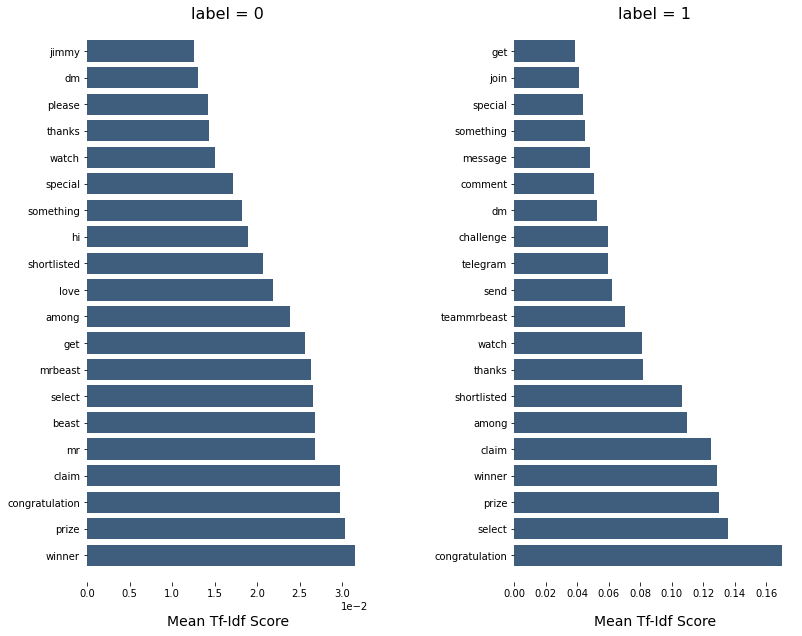

c:\Users\Jbcse\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Jbcse\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9450 missing from current font.
  font.set_text(s, 0, flags=flags)


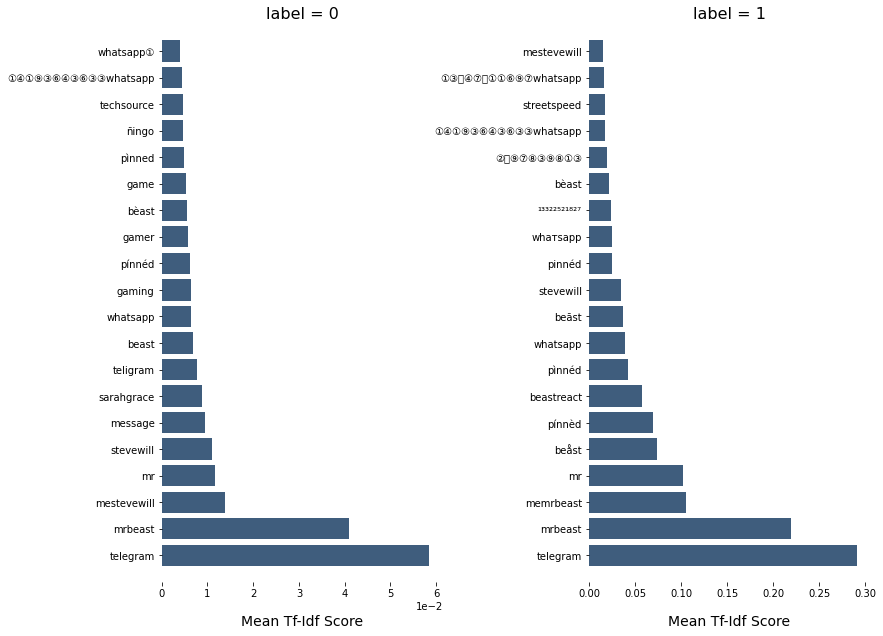

In [168]:
comments_features = tfidf_vectorizer.get_feature_names()
author_features = author_tfidf_vectorizer.get_feature_names()

def top_tfidf_feats(row, features, top_n = 25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)

plot_tfidf_classfeats_h(top_feats_by_class(X_train_vectors_tfidf, y_train, comments_features, top_n=20))
plt.show()
plot_tfidf_classfeats_h(top_feats_by_class(X_train_vectors_tfidf_author, y_train_author, author_features, top_n=20))
plt.show()


<p>
Now that we have the vectorized data, we can use it to train our models, we have tried different models, but the one with the best results is logistic regression.
</p>

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      9088
           1       0.75      0.82      0.78      2912

    accuracy                           0.89     12000
   macro avg       0.85      0.87      0.85     12000
weighted avg       0.89      0.89      0.89     12000

Confusion Matrix:
 [[8305  783]
 [ 533 2379]]
AUC: 0.9510136615969859


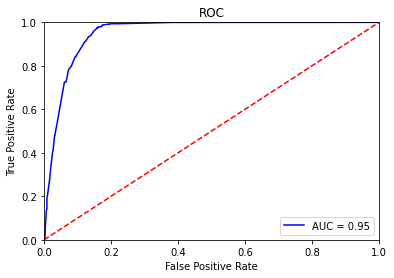

In [169]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)
joblib.dump(lr_tfidf, 'CommentTextModel')

#plot
plt.title("ROC")
plt.plot(fpr, tpr, 'b', label= 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      9150
           1       0.81      0.93      0.87      2850

    accuracy                           0.93     12000
   macro avg       0.89      0.93      0.91     12000
weighted avg       0.94      0.93      0.93     12000

Confusion Matrix:
 [[8538  612]
 [ 210 2640]]
AUC: 0.9819089828396127


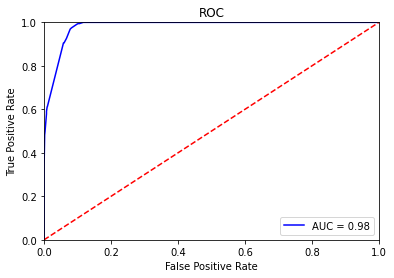

In [170]:

#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf_author=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf_author.fit(X_train_vectors_tfidf_author, y_train_author)  #model

y_predict = lr_tfidf_author.predict(X_test_vectors_tfidf_author)
y_prob = lr_tfidf_author.predict_proba(X_test_vectors_tfidf_author)[:,1]

print(classification_report(y_test_author,y_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test_author, y_predict))

fpr, tpr, thresholds = roc_curve(y_test_author, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)
joblib.dump(lr_tfidf_author, 'AuthorNameModel')

#plot
plt.title("ROC")
plt.plot(fpr, tpr, 'b', label= 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [171]:
#Pre-processing the new dataset
test['Clean Comments'] = test['Comments'].apply(lambda x: finalpreprocess(x)) #preprocess the data
test['Clean Author'] = test['Author'].apply(lambda x: finalpreprocess(x))

X_test = test['Clean Comments']
X_test_author = test['Clean Author']

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)
X_vector_author = author_tfidf_vectorizer.transform(X_test_author)

#use the best model to predict 'target' value for the new dataset 
lr_tfidf = joblib.load('CommentTextModel')
lr_tfidf_author = joblib.load('AuthorNameModel')

y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]

y_predict_author = lr_tfidf_author.predict(X_vector_author)
y_prob_author = lr_tfidf_author.predict_proba(X_vector_author)[:,1]

test['predict_prob']= y_prob
test['Is Scam']= y_predict
test['author_predict_prob'] = y_prob_author
test['Is Scam byAuthor'] = y_predict_author
final=test[['Clean Comments', 'Clean Author', 'predict_prob', 'author_predict_prob', 'Is Scam', 'Is Scam byAuthor', 'AuthorID']].reset_index(drop=True)

In [172]:
final[final['Is Scam'] == True]

,Clean Comments,Clean Author,predict_prob,author_predict_prob,Is Scam,Is Scam byAuthor,AuthorID
39,woww read profile picture,,0.538367,0.001825,1,0,UCa4SZGPlHL5AYIscbTqXdDQ
120,thanks watch leave comment telegram claim prize,telegram mrbeast,0.595759,0.657737,1,1,UC93veh5Su4UfpSW5npM1NUg
139,thanks watch leave comment telegram claim prize,telegram mrbeast,0.595759,0.657737,1,1,UC93veh5Su4UfpSW5npM1NUg
141,thanks watch leave comment telegram claim prize,telegram mrbeast,0.595759,0.657737,1,1,UC93veh5Su4UfpSW5npM1NUg
143,thanks watch leave comment telegram claim prize,telegram mrbeast,0.595759,0.657737,1,1,UC93veh5Su4UfpSW5npM1NUg
...,...,...,...,...,...,...,...
4981,congratulation select among shortlisted winner,telegram memrbeast,0.690497,0.963724,1,1,UCYGbbdOfUAtBOFoiifA4cpw
4984,congratulation select among shortlisted winner,telegram memrbeast,0.690497,0.963724,1,1,UCYGbbdOfUAtBOFoiifA4cpw
4987,congratulation select among shortlisted winner,telegram memrbeast,0.690497,0.963724,1,1,UCYGbbdOfUAtBOFoiifA4cpw
4991,congratulation select among shortlisted winner,telegram memrbeast,0.690497,0.963724,1,1,UCYGbbdOfUAtBOFoiifA4cpw
